In [2]:
from google.colab import drive
drive.mount('/content/datasets')

Mounted at /content/datasets


In [3]:
path = "/content/datasets/MyDrive/preprocessed_01.csv"

In [4]:
import pandas as pd
df = pd.read_csv(path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      1205 non-null   int64  
 1   본사정원수           1205 non-null   float64
 2   본사휴가자수          1205 non-null   float64
 3   본사출장자수          1205 non-null   float64
 4   본사시간외근무명령서승인건수  1205 non-null   float64
 5   현본사소속재택근무자수     1205 non-null   float64
 6   day             1205 non-null   int64  
 7   morning_menu    1205 non-null   object 
 8   lunch_menu      1205 non-null   object 
 9   dinner_menu     1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(7), int64(2), object(3)
memory usage: 113.1+ KB


In [6]:
import matplotlib.pyplot as plt

def drawHistory(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.figure()
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

In [7]:
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [8]:
food = df['dinner_menu']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(food)

In [9]:
len(tokenizer.word_index)

1653

In [10]:
from keras.preprocessing import sequence
max_len=9

dinner_vector = tokenizer.texts_to_sequences(df['dinner_menu'])
dinner_train_x = sequence.pad_sequences(dinner_vector, maxlen=max_len)

dinner_train_x.shape

(1205, 9)

In [11]:
other_train_x = df[['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', 'day']]

In [12]:
y_train = df['석식계']

In [36]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=6),
    ModelCheckpoint(filepath='dinner.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
]

In [14]:
val_dinner = dinner_train_x[1000:]
dinner_train = dinner_train_x[:1000]

val_other = other_train_x[1000:]
other_train = other_train_x[:1000]

val_y_dinner = y_train[1000:]
y_dinner_train = y_train[:1000]

In [15]:
dinner_train.shape, other_train.shape, y_dinner_train.shape

((1000, 9), (1000, 6), (1000,))

In [16]:
val_dinner.shape, val_other.shape, val_y_dinner.shape

((205, 9), (205, 6), (205,))

In [17]:
val_data = {
    'dinner': val_dinner, 'other':val_other
}

val_targets = {
    'dinner_target': val_y_dinner
}

In [18]:
dinner_input = Input(shape=(None,), dtype='int32', name='dinner')
other_input = Input(shape=(6, ), dtype='float64', name='other')

embedding = layers.Embedding(len(tokenizer.word_index)+1, 32, input_length=max_len, mask_zero=True)

dinner_x = embedding(dinner_input)
dinner_x = layers.GRU(16)(dinner_x)

other_x = layers.Dense(4, activation='relu', input_shape=(6,))(other_input)

concatenated = layers.concatenate([dinner_x, other_x], axis=-1)

dinner_dense = layers.Dense(16, activation='relu')(concatenated)
dinner_prediction = layers.Dense(1, name='dinner_target')(dinner_dense)

model = Model([dinner_input, other_input], dinner_prediction)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dinner (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 32)     52928       dinner[0][0]                     
__________________________________________________________________________________________________
other (InputLayer)              [(None, 6)]          0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 16)           2400        embedding[0][0]                  
______________________________________________________________________________________________

In [37]:
model.compile(optimizer='rmsprop', 
              loss='mae', 
              metrics=['acc'])

history = model.fit({'dinner': dinner_train, 'other':other_train}, y_dinner_train, 
                    epochs=200, 
                    batch_size=64, 
                    callbacks=callbacks_list,
                    validation_split=0.2,
                    verbose=2)

Epoch 1/200
13/13 - 4s - loss: 39.3625 - acc: 0.0200 - val_loss: 86.9099 - val_acc: 0.0400
Epoch 2/200
13/13 - 0s - loss: 38.0776 - acc: 0.0175 - val_loss: 86.7468 - val_acc: 0.0500
Epoch 3/200
13/13 - 0s - loss: 38.0417 - acc: 0.0225 - val_loss: 86.3300 - val_acc: 0.0400
Epoch 4/200
13/13 - 0s - loss: 37.7784 - acc: 0.0162 - val_loss: 85.6786 - val_acc: 0.0500
Epoch 5/200
13/13 - 0s - loss: 37.5777 - acc: 0.0237 - val_loss: 85.9800 - val_acc: 0.0450
Epoch 6/200
13/13 - 0s - loss: 37.2541 - acc: 0.0188 - val_loss: 86.5548 - val_acc: 0.0500
Epoch 7/200
13/13 - 0s - loss: 37.1344 - acc: 0.0200 - val_loss: 86.3995 - val_acc: 0.0400
Epoch 8/200
13/13 - 0s - loss: 36.6570 - acc: 0.0175 - val_loss: 86.1320 - val_acc: 0.0500
Epoch 9/200
13/13 - 0s - loss: 36.3025 - acc: 0.0200 - val_loss: 86.2935 - val_acc: 0.0400
Epoch 10/200
13/13 - 0s - loss: 35.9470 - acc: 0.0200 - val_loss: 85.9653 - val_acc: 0.0400


In [38]:
model.evaluate(val_data, val_targets)

7/7 [==============================] - 1s 6ms/step - loss: 150.0848 - acc: 0.0049


[150.08480834960938, 0.004878048785030842]

In [39]:
y = model.predict(val_data)

In [40]:
y[:5], val_y_dinner[:5]

(array([[410.9848 ],
        [568.51025],
        [306.95932],
        [427.622  ],
        [293.9527 ]], dtype=float32), 1000    379.0
 1001    640.0
 1002    575.0
 1003    487.0
 1004    614.0
 Name: 석식계, dtype: float64)

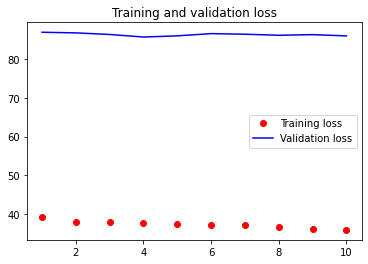

In [41]:
drawHistory(history)

In [24]:
import numpy as np

test = pd.read_csv("/content/datasets/MyDrive/test.csv")

for col in ['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']:
    test[col] -= np.mean(test[col])
    test[col] /= np.std(test[col])

test['day'] = test['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})

In [25]:
dinner_test_x = tokenizer.texts_to_sequences(test['석식메뉴'])
dinner_test_x = sequence.pad_sequences(dinner_test_x, maxlen=max_len)

other_test_x = test[['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', 'day']]

In [42]:
prediction = model.predict({'dinner': dinner_test_x, 
                            'other':other_test_x})

In [43]:
prediction

array([[  2.1503081],
       [ 40.09017  ],
       [ 30.47128  ],
       [ 91.80409  ],
       [118.04415  ],
       [114.62113  ],
       [159.30185  ],
       [104.53295  ],
       [105.786606 ],
       [ 94.18279  ],
       [ 52.662834 ],
       [ 50.74967  ],
       [ 34.945045 ],
       [ 31.94349  ],
       [100.39169  ],
       [ 78.91775  ],
       [201.51608  ],
       [233.83351  ],
       [163.15643  ],
       [213.2689   ],
       [148.04326  ],
       [159.01959  ],
       [ 56.859173 ],
       [176.0648   ],
       [113.92678  ],
       [169.17175  ],
       [169.64104  ],
       [ 96.83942  ],
       [156.8228   ],
       [ 70.47652  ],
       [ 93.0036   ],
       [ 24.403078 ],
       [ 25.442345 ],
       [ 21.311956 ],
       [ 56.539944 ],
       [ 33.072075 ],
       [ 59.248814 ],
       [ 36.89219  ],
       [ 86.16443  ],
       [ 72.59987  ],
       [ 70.08661  ],
       [ 94.36518  ],
       [ 34.79929  ],
       [ 90.39091  ],
       [ 82.510056 ],
       [ 5

In [ ]:
submission = pd.read_csv("/content/datasets/MyDrive/sample_submission.csv")
submission['석식계'] = prediction
submission.to_csv('/content/datasets/MyDrive/dinner.csv', index=False)

In [44]:
submission = pd.read_csv("/content/datasets/MyDrive/lunch.csv")
submission['석식계'] = prediction
submission.to_csv('/content/datasets/MyDrive/lunch_and_dinner.csv', index=False)